# FEniCS en 1D

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

Ejecutar este documento en forma dinámica: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_1D/fem1D_introFEniCS.ipynb)


Para correr en google colab ejecutar la siguientes instrucciones (https://fem-on-colab.github.io/).


In [1]:
%%capture  
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


## Ecuación de Poisson en 1D 

En el [tutorial introductorio de FEM en 1D](https://nbviewer.jupyter.org/github/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_1D/fem1D.ipynb) utilizamos un ejemplo para resolver la ecuación de Poisson con condiciones de borde de Dirichlet en un intervalo entre 0 y 1. Para esto programamos el método hasta obtener la matriz de rigidez y el vector de cargas, y finalmente resolvimos el sistema lineal. En este tutorial resolveremos el mismo problema pero utilizando FEniCS. De esta manera, aprenderemos a escribir un script de FEniCS con algunas de sus herramientas.

Recordemos la ecuación:

$$ \left \{ \begin{array}{l} -u^{''}=f \ \ \text{ para } \ \ x\in I=\left(0,1 \right) \\   u(0)=u(1)=0 \end{array} \right . \tag{1}$$

Continuaremos resolviendo el caso particular de $f=1$. Obtuvimos la formulación variacional y llegamos a:

$$\int_{0}^{1}v^{'}u^{'} \ \ dx = \int_{0}^{1} fv \ \ dx  \ \ \ \ \forall \ \ v \ \ \in V_{0}.\tag{2}$$

El dominio donde vive $u$ también es $V_{0}$.

## Script de FEniCS

Comencemos entonces con el script de FEniCS. Primero debemos importar FEniCS, luego definimos el número de segmentos en que queremos dividir el intervalo $I$. Luego utilizamos la función [IntervaMesh](https://fenicsproject.org/docs/dolfin/1.5.0/python/programmers-reference/cpp/mesh/IntervalMesh.html) para crear una malla uniforme en una dimensión.

In [2]:
from __future__ import print_function
from fenics import *

nx = 5 #numero de segmentos
minx, maxx = 0.0, 1.0 #límites del intervalo
mesh = IntervalMesh(nx, minx, maxx)#malla en 1D 
print(type(mesh))

<class 'dolfin.cpp.generation.IntervalMesh'>


En mesh se guarda la malla generada. Existen funciones similares a IntervalMesh para generar mallas en 2D (por ejemplo: [UnitSquareMesh](https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/cpp/mesh/UnitSquareMesh.html)). Estas funciones pertenecen al conjunto generadores built-in de mallas de FEniCS, las utilizaremos para ejemplos simples. Para ejemplos un poco más complejos, generaremos mallas con Gmsh.

Siguiendo con el script, lo que debemos hacer es crear el espacio donde vivirán tanto las solución como la función de prueba ($V_{0}$). Esto lo hacemos de la siguiente manera:

In [3]:
V0 = FunctionSpace(mesh, 'CG',1)

notemos que como argumento tiene la malla, en 'CG' viene de  Continuous Galerkin y significa que son los elementos continuos de Lagrange de orden 1 (las funciones sombrero del [tutorial anterior](https://nbviewer.jupyter.org/github/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_1D/fem1D.ipynb)). Algo de información sobre estas funciones [aquí](http://femwiki.wikidot.com/elements:lagrange-elements). Algo de información de la función FunctionSpace [aquí](https://fenicsproject.org/docs/dolfin/1.5.0/python/programmers-reference/functions/functionspace/FunctionSpace.html).

Para las condiciones de borde de Dirichlet tenemos que definir unas funciones que al llamarlas nos den TRUE cuando nos encontremos en el borde y FALSE en caso contrario. Para otro tipo de condiciones de borde (Neumann o Robin) lo debemos hacer de una forma diferente que lo veremos más adelante.

In [4]:
def borde_D(x, on_boundary): #retorna un booleano
    tol = 1.E-14
    return on_boundary and near(x[0],1.0, tol)

def borde_I(x, on_boundary):
    tol = 1.E-14
    return on_boundary and near(x[0], 0.0, tol)

La función near devuelve verdadero cuando x está cerca de 1.0 (para borde_D) con una tolerancia definida en la variable tol. Luego con la función DirichletBC le indicamos cuanto debe valer.

In [5]:
bc_der = DirichletBC(V0, Constant(0.0), borde_D)
bc_iz = DirichletBC(V0, Constant(0.0), borde_I)
bc = [bc_iz, bc_der]#Las guardamos en una lista!

Es importante destacar que podemos ir acumulandolas en una lista.

Ahora comenzaremos con la función variacional. Primero, definiremos la **función de prueba** (test) y la **función ensayo** (trial). 

In [6]:
u = TrialFunction(V0)
v = TestFunction(V0)
f = Constant(1.0)

FEniCS utiliza la denominada notación canónica para problemas variacionales, esto es una manera simple de escribir Ec. (2). Denominando:

$$ \begin{array}{l}a\left( u,v\right) = \int v^{'}u^{'} \ \ dx   \\ L \left(v \right) = \int fv \ \ dx   \end{array} \tag{3}$$

aquí, $a\left(u,v\right)$ es la forma bilineal (depende de $u$ y $v$) y la forma lineal (depende solo de $v$). En FEniCS esto se codifica casi literalmente:

In [7]:
a = dot(grad(u), grad(v))*dx
L = f*v*dx

Luego, debemos indicarle a FEniCS que ahora $u$ será una función y que deberá resolver y guardarla en esa variable.

In [8]:
u = Function(V0)
solve(a == L, u, bc)

Solving linear variational problem.


A la función solve le pasamos como argumento la formulación débil (variacional), la función $u$ donde queremos guardar la solución, y las condiciones de borde (Dirichlet) del problema. Podemos ver que tipo de variable es $u$.

In [9]:
print('Tipo de variable:',type(u))

Tipo de variable: <class 'dolfin.function.function.Function'>


El problema ya está resuelto. En la variable $u$ tenemos la solución por elementos finitos.

## Graficamos la solución y algunas cosas más

Para esto debemos utilizar matplotlib.

In [10]:
import matplotlib.pyplot as plt

Para obtener la solución en los nodos de la malla utilizamos la función compute_vertex_value.

In [11]:
print('solución en 0.134543: ',u(0.134543))
uh = u.compute_vertex_values(mesh) 
print('Cantidad de celdas:',nx)
print('Cantidad de vertices:',len(uh))

solución en 0.134543:  0.05381720000000001
Cantidad de celdas: 5
Cantidad de vertices: 6


Comparamos con la solución analítica:

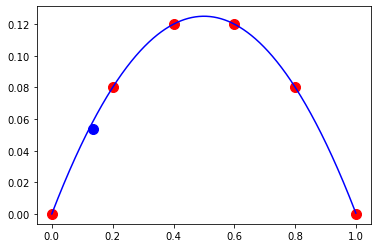

In [12]:
fig, axs = plt.subplots(1,1)
import numpy as np
xu = np.linspace(0.0, 1.0, len(uh),endpoint = True)
xe = np.arange(0.0,1.0,0.001)
ue = -0.5*xe*(xe-1.)
axs.plot(xu,uh,'ro',markersize=10)
axs.plot(0.134543,u(0.134543),'bo',markersize=10)
axs.plot(xe,ue,'b');
plt.show();

Para estimar el error, podemos utilizar la norma L2 y de esta manera computar el error que cometemos también entre los nodos.

In [13]:
class Resultado(UserExpression):
    def eval(self, values, x):
        values[0] = -0.5*x[0]*(x[0]-1.0)

u_D = Resultado(degree=1)
u_De = u_D.compute_vertex_values(mesh)
error_L2 = errornorm(u_D, u, 'L2')
print('Error en L2:',error_L2)

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error en L2: 0.0036514837167011004


Podemos ver las matriz A y vector b de la siguiente manera:

In [14]:
A = None
b = None

A = assemble(a,tensor = A)
print('Matriz de rigidez:')
print(A.array())

b = assemble(L, tensor=b)
print('Vector de cargas:')
print(b.get_local())


Matriz de rigidez:
[[ 5. -5.  0.  0.  0.  0.]
 [-5. 10. -5.  0.  0.  0.]
 [ 0. -5. 10. -5.  0.  0.]
 [ 0.  0. -5. 10. -5.  0.]
 [ 0.  0.  0. -5. 10. -5.]
 [ 0.  0.  0.  0. -5.  5.]]
Vector de cargas:
[0.1 0.2 0.2 0.2 0.2 0.1]
